In [138]:
import time
import cv2
import cv2.aruco as aruco
import numpy as np
from realsense_depth import *
# import the necessary packages
from threading import Thread
from utlities import *
from control_class import *

## IMAGE RESOLUTION
WIDTH = 1280
HEIGHT = 720

In [263]:
t =[]
throttle_value = []
pitch_value = []
roll_value = []
x_corr =[]
y_corr =[]
z_corr =[]
e_x = []
e_y =[]
e_z =[]
depth_value =[]
x_value = []
y_value = []
P_t = []
I_t = []
D_t = []
fps = []
def drone_pose(frame ,matrix_coefficients, distortion_coefficients,id_no):
    ## MARKER SIZE OF DRONE
    MARKER_SIZE = 0.056
    rvec, tvec, markerPoints = cv2.aruco.estimatePoseSingleMarkers(corners[id_no], MARKER_SIZE, matrix_coefficients,distortion_coefficients)
    return frame,tvec,rvec
# defining an empty custom dictionary 
arucoDict = cv2.aruco.custom_dictionary(0, 4, 1)
# adding empty bytesList array to fill with 5 markers 
arucoDict.bytesList = np.empty(shape = (5, 2, 4), dtype = np.uint8)

# adding new markers
mybits = np.array([[0,1,0,0],[1,1,0,0],[1,0,1,0],[1,1,0,1]], dtype = np.uint8)
arucoDict.bytesList[0] = cv2.aruco.Dictionary_getByteListFromBits(mybits)
mybits = np.array([[1,1,1,1],[1,0,0,1],[1,0,0,1],[0,0,0,1],], dtype = np.uint8)
arucoDict.bytesList[1] = cv2.aruco.Dictionary_getByteListFromBits(mybits)
mybits = np.array([[0,0,0,1],[0,0,0,1],[1,0,1,0],[0,1,1,1]], dtype = np.uint8)
arucoDict.bytesList[2] = cv2.aruco.Dictionary_getByteListFromBits(mybits)
mybits = np.array([[0,0,0,0],[1,1,1,0],[1,0,1,1],[0,1,1,1],], dtype = np.uint8)
arucoDict.bytesList[3] = cv2.aruco.Dictionary_getByteListFromBits(mybits)
mybits = np.array([[0,0,1,0],[1,0,1,0],[0,0,0,0],[1,1,1,1]], dtype = np.uint8)
arucoDict.bytesList[4] = cv2.aruco.Dictionary_getByteListFromBits(mybits)

arucoParams = aruco.DetectorParameters_create()

calibration_matrix_path = "calibration_matrix.npy"
distortion_coefficients_path = "distortion_coefficients.npy"
    
k = np.load(calibration_matrix_path)
d = np.load(distortion_coefficients_path)

# initialize the video stream and allow the camera sensor to warm up
print("[INFO] starting video stream...")

time.sleep(2.0)

# Initialize the video stream
reached = False
first_time = True

num_not_detected = 0
eps = 0.1
desired_depth = 2.2
# PID PARAMETERS
command = Command("192.168.4.1")
## MEAN - HOVERING VALUES
# mean_roll =  1511
# mean_pitch = 1482
# mean_throttle = 1475

dc = DepthCamera(width=WIDTH, height=HEIGHT)
error = np.zeros(4)
derr = np.zeros(4)
error_sum = np.zeros(4)
prev_err = np.zeros(4)
## PITCH,ROLL,THROTTLE,YAW
kp = np.array([16,16,15,0])
ki = np.array([3.5,3,3,0])
kd = np.array([1.5,1.5,0.5,0])
mean_vals = np.array([1500,1500,1470,1500])
# mean_roll =  1510
# mean_pitch = 1513
# mean_throttle = 1470
# mean_yaw = 1500
mean_roll =  1500
mean_pitch = 1500
mean_throttle = 1500
mean_yaw = 1500
slope = 0
for i in range(10):
    command.disarm()
    time.sleep(0.1)
# command.calib()

time.sleep(0.3)
for i in range(10):
    command.disarm()
    time.sleep(0.1)
command.takeoff()
time.sleep(0.2)
prev_time = time.time()
f_old = prev_time
start = f_old
print('[INFO] : Takeoff Completed')
try:
    while True:

        ret, color_frame = dc.get_frame()

        gray = cv2.cvtColor(color_frame,cv2.COLOR_BGR2GRAY)
        (corners, ids, rejected) = cv2.aruco.detectMarkers(gray,arucoDict, parameters=arucoParams)

        if  0 in ids : 
                #print(ids)
                ids = ids.tolist()
                #print('Tracking drone')
                #print(corne)
                i = ids.index([0])

                if ( abs(corners[i][0][1][0] - corners[i][0][0][0]) > 100 or abs(corners[i][0][1][1] - corners[i][0][0][1]) > 100 ) :
                    print(' [ERROR] : Large Marker detected ...')
                
                color_frame,xc,yc = aruco_display(color_frame,corners[i])
                frame,tvec,rvec = drone_pose(color_frame,k,d,i)
                x = tvec[0][0][0]
                y = tvec[0][0][1]
                z = tvec[0][0][2]

                # point1 = corners[i][0][0] + corners[i][0][3]
                # point2 = corners[i][0][1] + corners[i][0][2]

                point1 = corners[i][0][1] 
                point2 = corners[i][0][3] 
                if point1[0] == point2[0]:
                    slope = 20
                else: 
                    slope =  np.tan((point1[1] - point2[1])/(point1[0] - point2[0]))
                num_not_detected = 0

        else :
            print('[INFO] : Drone not detected ...')
            if num_not_detected > 25:
                print('[INFO] : Drone out of range...')
                print('[INFO] : Landing ...')
                command.land()
                print('[INFO] : Quitting ...')
                break

            num_not_detected +=1
            
            command.set_attitude(mean_throttle,mean_yaw,mean_pitch,mean_roll)
            #time.sleep(0.1)
            continue
        
        ## HOVERING 
        if first_time:
            desired_pos = np.array([x,y,desired_depth,0])
   
            first_time = False
        else:
            #depth = dc.get_depth(xc,yc)
            depth = z
            curr_pos = np.array([x,y,depth,slope])
        
            if(np.linalg.norm(desired_pos - curr_pos) < 0.2):
                print('[INFO] : Reached Position')
                kd = [0.5,0.5,0.5,0]
                

            if(np.abs(desired_pos[2] - curr_pos[2]) < 0.1):
                # kd[2] = 2
                # ki[2] = 4
                # #kp[2] = 5
                reached = True
            print('desired pos : ',desired_pos)
            print('curr_pos :', curr_pos )

            curr_time = time.time()
            t.append(curr_time-start)
            #time_ = curr_time-prev_time
            time_ = 0.045
            error = curr_pos-desired_pos
            derr = (error -prev_err)/(time_)

            P = kp*error
            I = ki*error_sum
            D =  kd*derr
            print(P,I,D)
            result = P+I+D
            P_t.append(P[2])
            D_t.append(D[2])
            I_t.append(I[2])
            print(result)
            x_corr.append(result[0])
            y_corr.append(result[1])
            z_corr.append(result[2])
            # pitch = mean_vals[0] + result[0]
            # roll = mean_vals[1] + result[1]
            # throttle = mean_vals[2] + result[2]
            # yaw = mean_vals[3] + result[3]
            result = mean_vals+ (np.rint(result)).astype(int)
            
            depth_value.append(curr_pos[2])
            x_value.append(curr_pos[0])
            y_value.append(curr_pos[1])
            e_x.append(error[0])
            e_y.append(error[1])
            e_z.append(error[2])
            throttle_value.append(result[2])
            pitch_value.append(result[0])
            roll_value.append(result[1])

            print("pitch : ",result[0])
            print("roll : ",result[1])
            print("throttle : ",result[2])
            print("yaw : ",result[3])
            command.set_attitude(throttle = result[2], yaw = result[3],pitch = result[0],roll = result[1])
            error_sum += error*(time_)
            prev_time = curr_time

            cv2.imshow("Frame", color_frame)

            
        key = cv2.waitKey(1) & 0xFF
        # if the `q` key was pressed, break from the loop
        if key == ord("q"):
            break
        ## Updating the current time for FPS Calculation
        f_new = time.time()
        fps_ = 1/(f_new-f_old)
        fps.append(fps_)
        f_old = f_new
        print('[INFO] : fps = ',fps_)

        # Restricting FPS
        # time.sleep(0.01)

except KeyboardInterrupt:
    print('[INFO] : Keyboard Interrupt')
    command.boxarm()
    command.land()
except:
    print('[INFO] : Exception')
    command.boxarm()
    command.land()

    
dc.release()
cv2.destroyAllWindows()


[INFO] starting video stream...
DepthCamera
[INFO] : Takeoff Completed
[INFO] : Drone not detected ...
[INFO] : fps =  [10.56268273703244]
[INFO] : Drone not detected ...
[INFO] : Drone not detected ...
desired pos :  [-0.13851909 -0.38745569  2.2         0.        ]
curr_pos : [-0.12943627 -0.38161171  3.47310119 -1.52749848]
[ 0.14532518  0.09350359 19.09651788 -0.        ] [0. 0. 0. 0.] [ 0.34060588  0.21914904 15.9137649  -0.        ]
[ 0.48593106  0.31265263 35.01028278  0.        ]
pitch :  1500
roll :  1500
throttle :  1505
yaw :  1500
[INFO] : fps =  [10.56268273703244, 8.128102320624]
desired pos :  [-0.13851909 -0.38745569  2.2         0.        ]
curr_pos : [-0.12529829 -0.38612367  3.46293565 -1.52749848]
[ 0.21153293  0.02131226 18.9440348  -0.        ] [ 0.0012716   0.00070128  0.15277214 -0.        ] [ 0.4957803   0.0499506  15.78669567 -0.        ]
[ 0.70858482  0.07196413 34.88350261 -0.        ]
pitch :  1501
roll :  1500
throttle :  1505
yaw :  1500
[INFO] : fps =  [

271
True


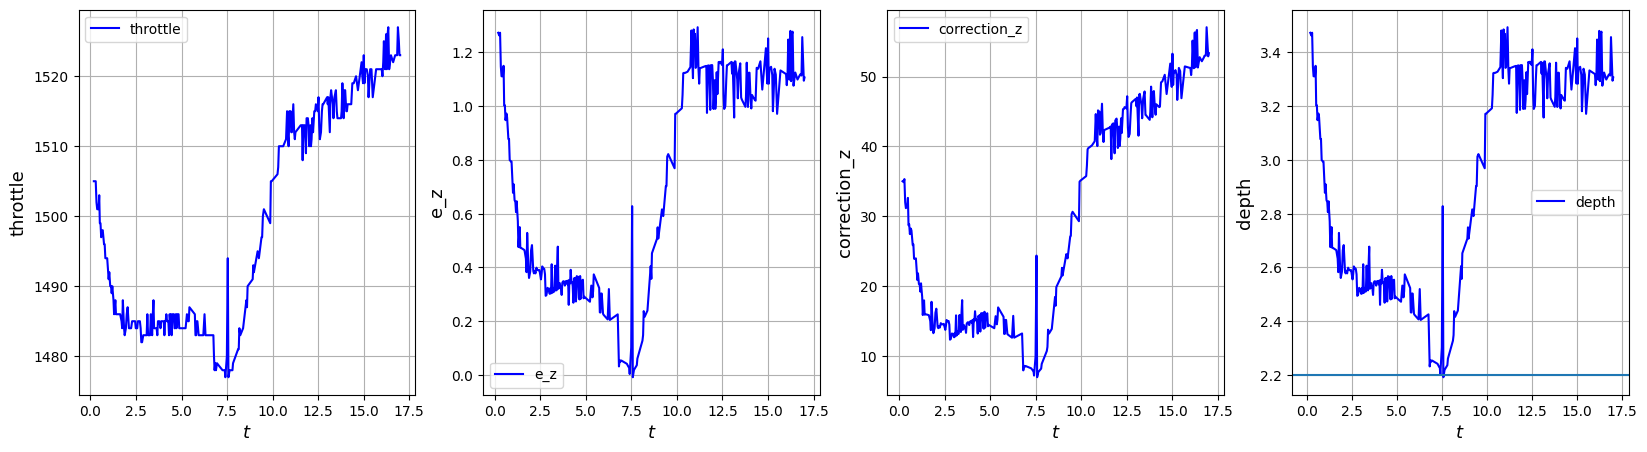

In [264]:
print(len(t))
print(reached)
#print(t)
from matplotlib import pyplot as plt
#ploting
f,ax = plt.subplots(1,4,figsize=(20,5))
#f.suptitle(f'Kp_T ={Kp_T}, Ki_T ={Ki_T}, Kd_T ={Kd_T}')
ax[0].plot(t,throttle_value,'b',label ='throttle')
ax[0].set_xlabel('$t$',fontsize=13)
ax[0].set_ylabel('throttle',fontsize=13)
ax[0].grid(True)
ax[0].legend()
ax[1].plot(t,e_z,'b',label='e_z')
ax[1].set_xlabel('$t$',fontsize=13)
ax[1].set_ylabel('e_z',fontsize=13)
ax[1].grid(True)
ax[1].legend()
ax[2].plot(t,z_corr,'b',label ='correction_z')
ax[2].set_xlabel('$t$',fontsize=13)
ax[2].set_ylabel('correction_z',fontsize=13)
ax[2].grid(True)
ax[2].legend()
ax[3].plot(t,depth_value,'b',label ='depth')
ax[3].set_xlabel('$t$',fontsize=13)
ax[3].set_ylabel('depth',fontsize=13)
ax[3].grid(True)
ax[3].axline((0,desired_depth),slope=0)
ax[3].legend()
#str ="image/"+f'Kp_T ={Kp_T}, Ki_T ={Ki_T}, Kd_T ={Kd_T}'+'.png'
#f.savefig(str)

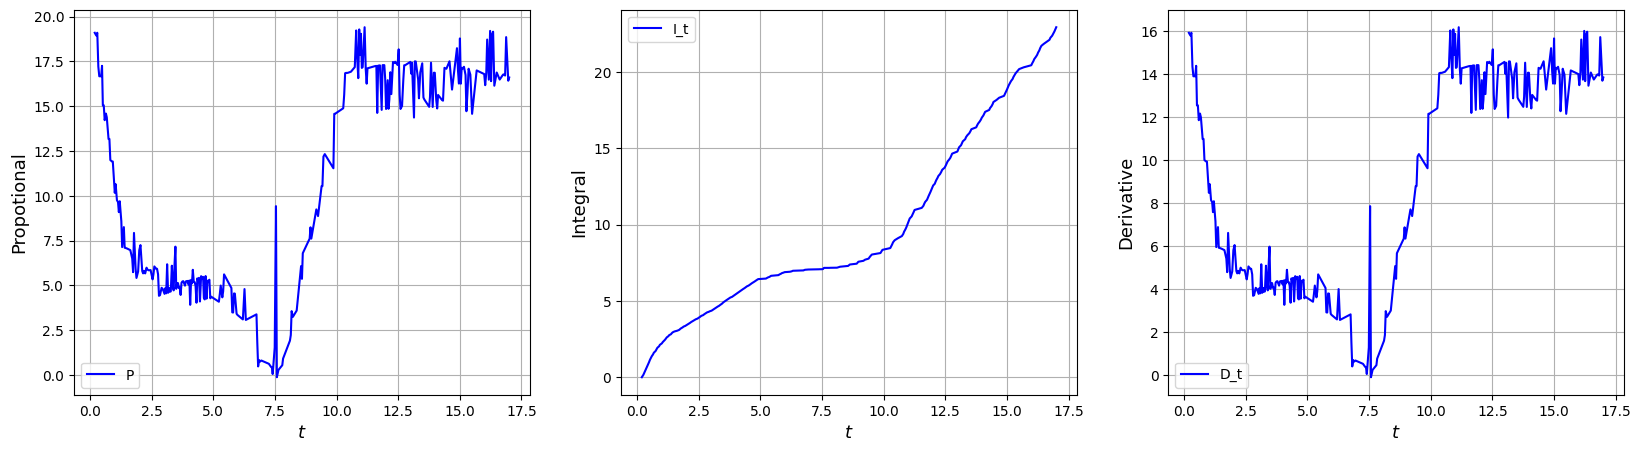

In [265]:
f,ax = plt.subplots(1,3,figsize=(20,5))
#f.suptitle(f'Kp_T ={Kp_T}, Ki_T ={Ki_T}, Kd_T ={Kd_T}')
ax[0].plot(t,P_t,'b',label ='P')
ax[0].set_xlabel('$t$',fontsize=13)
ax[0].set_ylabel('Propotional',fontsize=13)
ax[0].grid(True)
ax[0].legend()
ax[1].plot(t,I_t,'b',label='I_t')
ax[1].set_xlabel('$t$',fontsize=13)
ax[1].set_ylabel('Integral',fontsize=13)
ax[1].grid(True)
ax[1].legend()

ax[2].plot(t,D_t,'b',label ='D_t')
ax[2].set_xlabel('$t$',fontsize=13)
ax[2].set_ylabel('Derivative',fontsize=13)
ax[2].grid(True)
ax[2].legend()

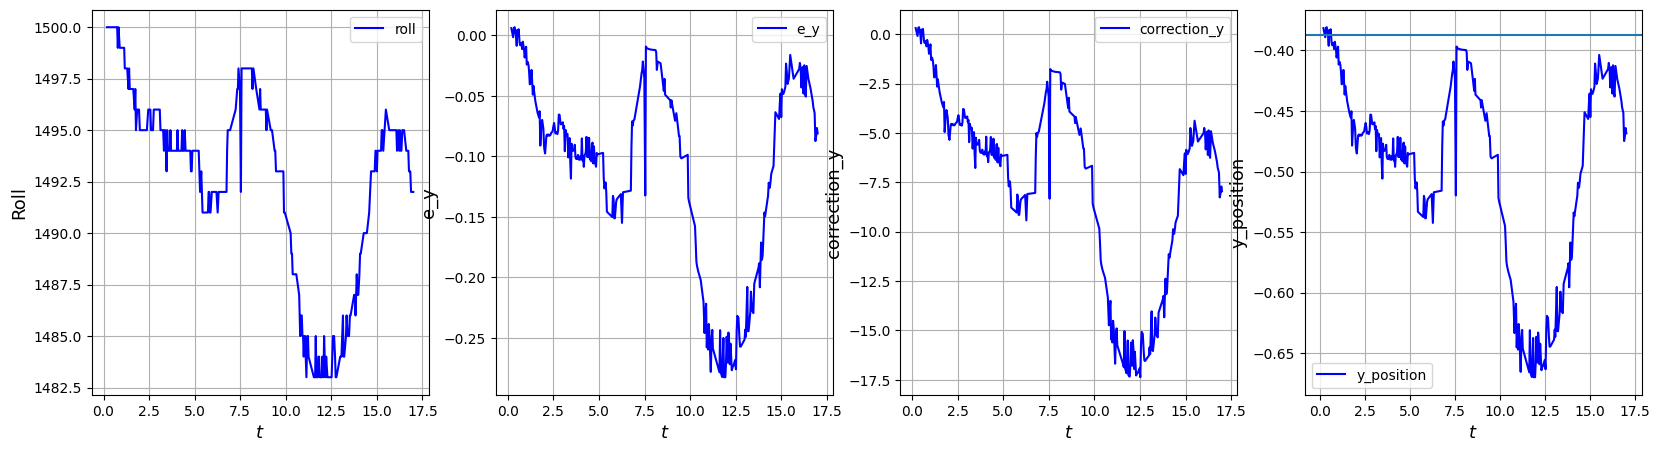

In [266]:
#ploting
f,ax = plt.subplots(1,4,figsize=(20,5))
#f.suptitle(f'Kp_R ={Kp_R}, Ki_R ={Ki_R}, Kd_R ={Kd_R}')
ax[0].plot(t,roll_value,'b',label ='roll')
ax[0].set_xlabel('$t$',fontsize=13)
ax[0].set_ylabel('Roll',fontsize=13)
ax[0].grid(True)
ax[0].legend()
ax[1].plot(t,e_y,'b',label='e_y')
ax[1].set_xlabel('$t$',fontsize=13)
ax[1].set_ylabel('e_y',fontsize=13)
ax[1].grid(True)
ax[1].legend()
ax[2].plot(t,y_corr,'b',label ='correction_y')
ax[2].set_xlabel('$t$',fontsize=13)
ax[2].set_ylabel('correction_y',fontsize=13)
ax[2].grid(True)
ax[2].legend()
ax[3].plot(t,y_value,'b',label ='y_position')
ax[3].set_xlabel('$t$',fontsize=13)
ax[3].set_ylabel('y_position',fontsize=13)
ax[3].grid(True)
ax[3].axline((0,desired_pos[1]),slope = 0)
ax[3].legend()

#st ="image/"+f'Kp_R ={Kp_R}, Ki_R ={Ki_R}, Kd_R ={Kd_R}'+'.png'
#f.savefig(st)

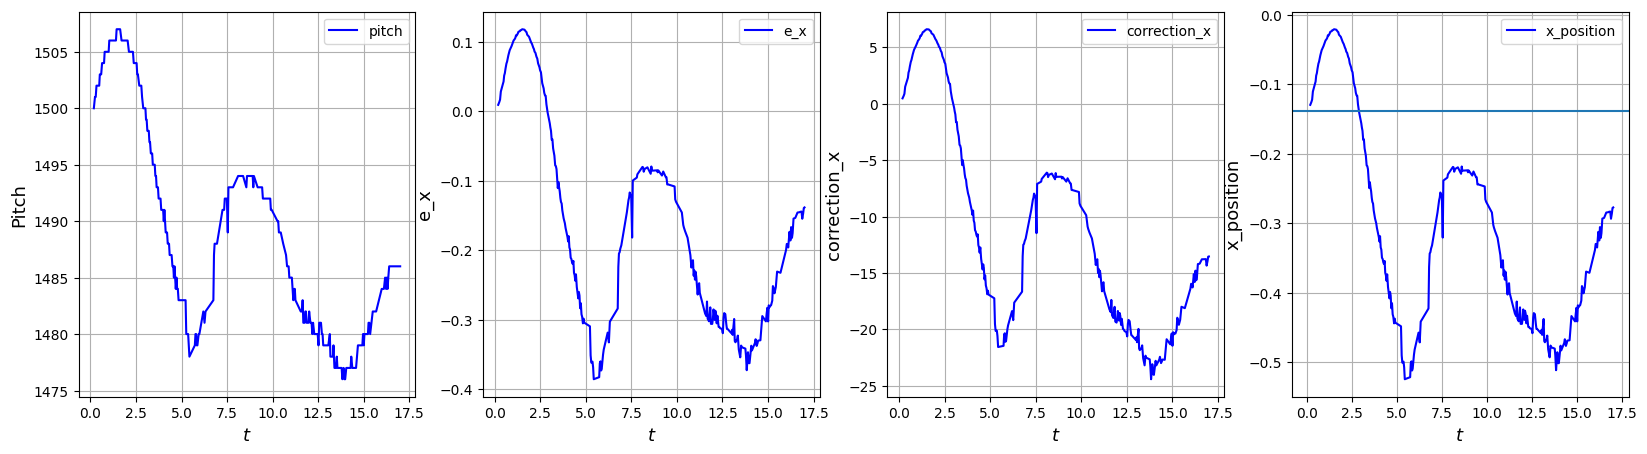

In [267]:
#ploting
f,ax = plt.subplots(1,4,figsize=(20,5))
#f.suptitle(f'Kp_P ={Kp_P}, Ki_P ={Ki_P}, Kd_P ={Kd_P}')
ax[0].plot(t,pitch_value,'b',label ='pitch')
ax[0].set_xlabel('$t$',fontsize=13)
ax[0].set_ylabel('Pitch',fontsize=13)
ax[0].grid(True)
ax[0].legend()
ax[1].plot(t,e_x,'b',label='e_x')
ax[1].set_xlabel('$t$',fontsize=13)
ax[1].set_ylabel('e_x',fontsize=13)
ax[1].grid(True)
ax[1].legend()
ax[2].plot(t,x_corr,'b',label ='correction_x')
ax[2].set_xlabel('$t$',fontsize=13)
ax[2].set_ylabel('correction_x',fontsize=13)
ax[2].grid(True)
ax[2].legend()
ax[3].plot(t,x_value,'b',label ='x_position')
ax[3].set_xlabel('$t$',fontsize=13)
ax[3].set_ylabel('x_position',fontsize=13)
ax[3].grid(True)
ax[3].axline((0,desired_pos[0]),slope = 0)
ax[3].legend()
#st ="image/"+f'Kp_P ={Kp_P}, Ki_P ={Ki_P}, Kd_P ={Kd_P}'+'.png'
#f.savefig(st)

22.111139883656236


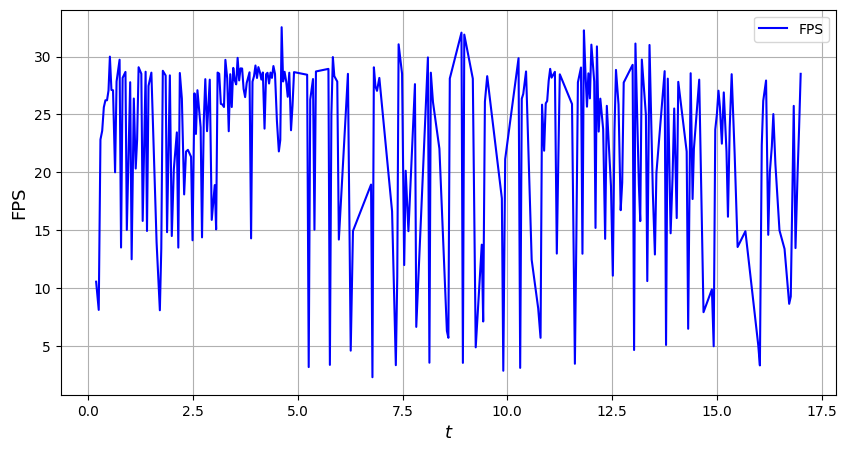

In [268]:
f,ax = plt.subplots(1,1,figsize=(10,5))
#f.suptitle(f'Kp_P ={Kp_P}, Ki_P ={Ki_P}, Kd_P ={Kd_P}')
ax.plot(t,fps[:len(t)],'b',label ='FPS')
ax.set_xlabel('$t$',fontsize=13)
ax.set_ylabel('FPS',fontsize=13)
ax.grid(True)
ax.legend()
print(np.mean(fps))